In [76]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from numpy import random
import seaborn as sb

In [77]:
## Load data
data = pd.read_csv('data/77_cancer_proteomes_CPTAC_itraq.csv',header=0,index_col=0)
clinical = pd.read_csv('data/clinical_data_breast_cancer.csv',header=0,index_col=0) ## holds clinical information about each patient/sample
pam50 = pd.read_csv('data/PAM50_proteins.csv',header=0)

In [78]:
data

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_001191293,NaN,protein FAM24B precursor,NaN,NaN,NaN,-16.029761,1.729692,4.107251,-9.584499,-5.196859,...,-6.662350,NaN,NaN,NaN,NaN,NaN,NaN,-8.020071,-3.093822,-4.602418
NP_775791,NaN,putative uncharacterized protein C9orf62,NaN,NaN,NaN,-2.046065,-0.425182,-3.203370,-4.786183,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049608,-0.646977,0.240590
NP_004065,COX8A,"cytochrome c oxidase subunit 8A, mitochondrial",NaN,NaN,NaN,-1.778435,-0.149673,1.971481,-3.103949,-0.933726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

In [80]:
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

In [81]:
data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [82]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()

In [83]:
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [84]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

In [85]:
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [86]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)

In [87]:
## Change name to make it look nicer in the code!
processed = merged

In [88]:
processed

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A138,2.765081,2.779709,2.779709,2.797995,2.787023,2.779709,2.783366,2.783366,2.205538,0.749997,...,HER2-enriched,-5,-2,1,2,Basal,2,1,3,2
TCGA-D8-A142,0.538596,0.542211,0.542211,0.534981,0.542211,0.542211,0.542211,0.542211,-0.148205,0.267490,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-E2-A154,0.862659,0.870186,0.870186,0.866423,0.870186,0.870186,0.870186,0.870186,1.920171,2.349197,...,Luminal A,-3,-12,6,4,LumA,2,3,3,3
TCGA-E2-A158,-1.086529,-1.095492,-1.095492,-1.095492,-1.095492,-1.093252,-1.093252,-1.093252,0.096627,-1.149272,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [89]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

In [90]:
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.loc[:, processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

In [91]:
## Impute missing values (maybe another method would work better?)
from sklearn.impute import SimpleImputer

# Create a SimpleImputer with the median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data and transform the data to fill missing values
processed_numerical_p50 = imputer.fit_transform(processed_numerical_p50)

In [92]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
 
from sklearn.cluster import KMeans
from sklearn import metrics

n_clusters = [2, 3, 4, 5, 6, 7, 8, 10, 20, 79]

def compare_k_means(k_list, processed_numerical_p50):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_init=10)
        clusterer.fit(processed_numerical_p50)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(processed_numerical_p50, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_), 4)))
        print("------------------------")

# Assuming you have a 'data' variable that contains the data you want to cluster
compare_k_means(n_clusters, processed_numerical_p50)

Silhouette Coefficient for k == 2: 0.211
Homogeneity score for k == 2: 0.2073
------------------------
Silhouette Coefficient for k == 3: 0.1761
Homogeneity score for k == 3: 0.4138
------------------------
Silhouette Coefficient for k == 4: 0.1385
Homogeneity score for k == 4: 0.4302
------------------------
Silhouette Coefficient for k == 5: 0.142
Homogeneity score for k == 5: 0.4657
------------------------
Silhouette Coefficient for k == 6: 0.1139
Homogeneity score for k == 6: 0.4861
------------------------
Silhouette Coefficient for k == 7: 0.1078
Homogeneity score for k == 7: 0.5415
------------------------
Silhouette Coefficient for k == 8: 0.1065
Homogeneity score for k == 8: 0.5592
------------------------
Silhouette Coefficient for k == 10: 0.1014
Homogeneity score for k == 10: 0.6119
------------------------
Silhouette Coefficient for k == 20: 0.0874
Homogeneity score for k == 20: 0.6817
------------------------
Silhouette Coefficient for k == 79: 0.0087
Homogeneity score f

In [93]:
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)

In [94]:
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
compare_k_means(n_clusters,processed_numerical_p50)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!


Silhouette Coefficient for k == 2: 0.211
Homogeneity score for k == 2: 0.2073
------------------------
Silhouette Coefficient for k == 3: 0.1748
Homogeneity score for k == 3: 0.4159
------------------------
Silhouette Coefficient for k == 4: 0.1404
Homogeneity score for k == 4: 0.4084
------------------------
Silhouette Coefficient for k == 5: 0.1393
Homogeneity score for k == 5: 0.5592
------------------------
Silhouette Coefficient for k == 6: 0.1268
Homogeneity score for k == 6: 0.5018
------------------------
Silhouette Coefficient for k == 7: 0.1085
Homogeneity score for k == 7: 0.5756
------------------------
Silhouette Coefficient for k == 8: 0.1085
Homogeneity score for k == 8: 0.5568
------------------------
Silhouette Coefficient for k == 10: 0.0928
Homogeneity score for k == 10: 0.5726
------------------------
Silhouette Coefficient for k == 20: 0.0822
Homogeneity score for k == 20: 0.6892
------------------------
Silhouette Coefficient for k == 79: 0.0087
Homogeneity score 

In [98]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
clusterer_final = KMeans(n_clusters=3, n_init=10)
clusterer_final = clusterer_final.fit(processed_numerical_p50)
processed_p50_plot = pd.DataFrame(processed_numerical_p50)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)

#print("Cluster Labels:")
#print(clusterer_final.labels_)

#print("Sorted DataFrame:")
#print(processed_p50_plot)


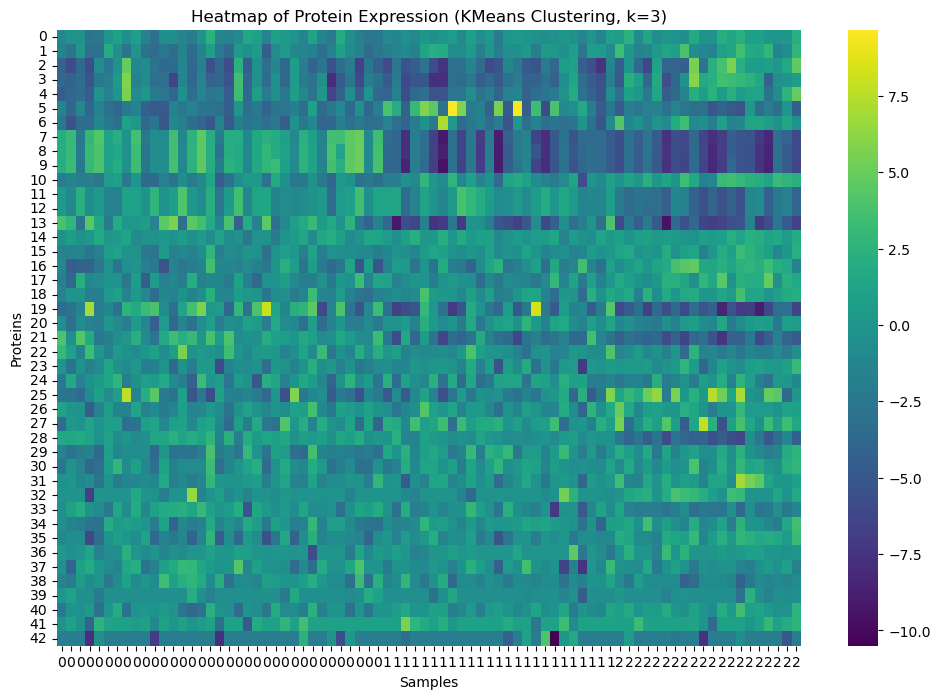

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the data by cluster labels
processed_p50_plot.sort_values('KMeans_cluster', axis=0, inplace=True)

# Extract the cluster labels
cluster_labels = processed_p50_plot['KMeans_cluster']

# Extract the protein expression data (excluding the cluster label column)
protein_expression_data = processed_p50_plot.drop(columns=['KMeans_cluster'])

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(protein_expression_data.T, cmap='viridis', cbar=True, xticklabels=cluster_labels.values)
plt.title('Heatmap of Protein Expression (KMeans Clustering, k=3)')
plt.xlabel('Samples')
plt.ylabel('Proteins')
plt.show()

In [100]:
import seaborn as sns
sns.scatterplot(data=processed_p50_plot, x='Feature1', y='Feature2', hue='KMeans_cluster', palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

ValueError: Could not interpret value `Feature1` for parameter `x`

<Axes: ylabel='Patient'>

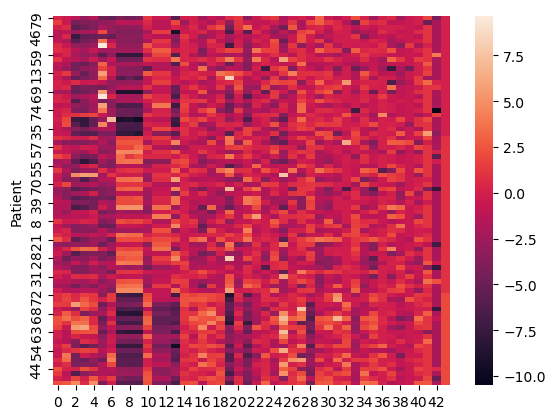

In [97]:
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
processed_p50_plot.index.name = 'Patient'
sb.heatmap(processed_p50_plot) 